In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
from typing import Callable

from fairdivision.algorithms.envy_cycle_elimination import envy_cycle_elimination
from fairdivision.algorithms.draft_and_eliminate import draft_and_eliminate
from fairdivision.algorithms.ordered_picking import ordered_picking
from fairdivision.algorithms.round_robin import round_robin
from fairdivision.algorithms.xp_ece import xp_ece
from fairdivision.utils.allocation import Allocation
from fairdivision.utils.generators import generate_agents, generate_items, generate_valuations, AdditiveGenerator, ValuationsGenerator

ALGORITHMS = [
    ("XP-ECE", xp_ece),
    ("Envy-Cycle Elimination", envy_cycle_elimination),
    ("Draft-and-Eliminate", draft_and_eliminate),
    ("Ordered Picking", ordered_picking),
    ("Round-Robin", lambda agents, items: round_robin(agents, items)[0])
]

In [36]:
def initialize_statistics(algorithms: list[tuple[str, Callable]] = ALGORITHMS) -> tuple[dict[str, np.ndarray], dict[str, np.ndarray]]:
    """
    Initializes means per each label and standard deviations per each label.

    Both means and standard deviations are dictionaries that contain an empty numpy array for every label in `algorithms`.
    """

    means_per_labels = {label: np.array([]) for label, _ in algorithms}
    stds_per_labels = {label: np.array([]) for label, _ in algorithms}

    return means_per_labels, stds_per_labels


def run_algorithms(
        n: int, 
        m: int, 
        generator: ValuationsGenerator, 
        iterations: int, 
        algorithms: list[tuple[str, Callable]] = ALGORITHMS) -> tuple[dict[str, np.ndarray], dict[str, np.ndarray]]:
    """
    Runs each algorithm `iterations` times and returns statistics.

    In each iteration, `n` agents are created with random valuations for `m` items. Next, all `algorithms` are run for
    that instance with time measurement.

    Returns list of time measurements per algorithm.
    """
    
    measurements = []
    
    for _ in range(iterations):
        agents = generate_agents(n)
        items = generate_items(m)
        
        generate_valuations(agents, items, generator)

        measurement = {label: [] for label, _ in algorithms}

        for label, algorithm in algorithms:
            start_time = time.time()
            _ = algorithm(agents, items)
            measurement[label].append(time.time() - start_time)
        
        measurements.append(measurement)

    return measurements


def durations_to_statistics(measurements: list[dict[str, list[int]]], label: str) -> tuple[np.float64, np.float64]:
    """
    Calculates mean and standard deviation from collected `measurement` for a particular `label`.

    `measurements` is a list containing a dictionary for every iteration of the experiment. Each iteration has to run 
    the same algorithm and return a dictionary mapping labels to lists of durations. The function calculates the mean
    and standard deviation of the sums of durations for the given `label` over all iterations.
    """

    durations = np.array(list(map(lambda durations: sum(durations[label]), measurements)))

    mean = np.mean(durations)
    standard_deviation = np.std(durations)

    return mean, standard_deviation


def update_statistics(
        means_per_label: dict[str, np.ndarray],
        stds_per_label: dict[str, np.ndarray],
        measurements: list[dict[str, list[int]]],
        algorithms: list[tuple[str, Callable]] = ALGORITHMS) -> tuple[dict[str, np.ndarray], dict[str, np.ndarray]]:
    """
    For every label in `labels`, adds mean and standard deviation calculated from `measurements` to given
    `means_per_label` and `stds_per_label`.
    """

    for label, _ in algorithms:
        mean, std = durations_to_statistics(measurements, label)
        means_per_label[label] = np.concatenate((means_per_label[label], np.array([mean])))
        stds_per_label[label] = np.concatenate((stds_per_label[label], np.array([std])))

    return means_per_label, stds_per_label


def write_statistics(
        ms: np.ndarray, 
        means_per_label: dict[str, np.ndarray], 
        stds_per_label: dict[str, np.ndarray], 
        file_path: str) -> None:
    """
    Write statistics to a CSV file.
    """
    
    with open(file_path, "w+") as file:
        ms_strings = list(map(lambda items_number: str(items_number), list(ms)))
        file.write(f'items,{",".join(ms_strings)}\n')

        for algorithm_name, means in means_per_label.items():
            stds = stds_per_label[algorithm_name]

            means_string = ",".join(list(map(lambda mean: str(mean), list(means))))
            stds_string = ",".join(list(map(lambda std: str(std), list(stds))))

            file.write(f"{algorithm_name},{means_string}\n")
            file.write(f"{algorithm_name},{stds_string}\n")


def read_and_draw_statistics(
        file_path: str,
        xlabel: str,
        ylabel: str,
        title: str) -> None:
    """
    Plots a mean value with corresponding standard deviation for each label on one figure.
    """
    
    with open(file_path, "r") as file:
        ms_strings = list(filter(lambda token: len(token) > 0, file.readline().split(",")))
        ms = list(map(lambda items_number: int(items_number), ms_strings[1:]))

        statistics_per_label = []
        
        while True:
            means_line = file.readline()

            if len(means_line) == 0:
                break

            split_means_line = list(filter(lambda token: len(token) > 0, means_line.split(",")))

            algorithm_name = split_means_line[0]
            
            means = np.array(list(map(lambda mean: float(mean), split_means_line[1:])))
            
            split_stds_line = list(filter(lambda token: len(token) > 0, file.readline().split(",")))
            stds = np.array(list(map(lambda std: float(std), split_stds_line[1:])))

            statistics_per_label.append((algorithm_name, means, stds))
        
        plt.figure(figsize=(15, 6))
        
        plt.xlabel(xlabel, fontsize=20)
        plt.ylabel(ylabel, fontsize=20)

        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
    
        for label, means, stds in statistics_per_label:
            plt.plot(ms, means, label=label)
            plt.fill_between(ms, means - stds, means + stds, alpha=0.3)
    
        plt.xlim(ms[0], ms[-1])
        plt.ylim(bottom=0)
            
        plt.legend(fontsize=15)
        plt.title(title, fontsize=24)
    
        plt.show()

## Running the algorithm

### n = 5

In [29]:
n = 5
ms = np.arange(1, 101, 1)

generator = AdditiveGenerator(min=0, max=10)

iterations = 100

means, stds = initialize_statistics()

for m in ms:
    print(m, end=" ")
    measurements = run_algorithms(n, m, generator, iterations)
    means, stds = update_statistics(means, stds, measurements)

write_statistics(ms, means, stds, "data/comparison_execution_time_5.csv")

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

### n = 10

In [30]:
n = 10
ms = np.arange(1, 101, 1)

generator = AdditiveGenerator(min=0, max=10)

iterations = 100

means, stds = initialize_statistics()

for m in ms:
    print(m, end=" ")
    measurements = run_algorithms(n, m, generator, iterations)
    means, stds = update_statistics(means, stds, measurements)

write_statistics(ms, means, stds, "data/comparison_execution_time_10.csv")

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

### m = 4n

In [31]:
ns = np.arange(2, 31, 1)
ms = 4 * ns

generator = AdditiveGenerator(min=0, max=10)

iterations = 100

means, stds = initialize_statistics()

for n, m in zip(ns, ms):
    print(n, end=" ")
    measurements = run_algorithms(n, m, generator, iterations)
    means, stds = update_statistics(means, stds, measurements)

write_statistics(ms, means, stds, "data/comparison_execution_time_4n.csv")

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 

## Drawing charts

### n = 5

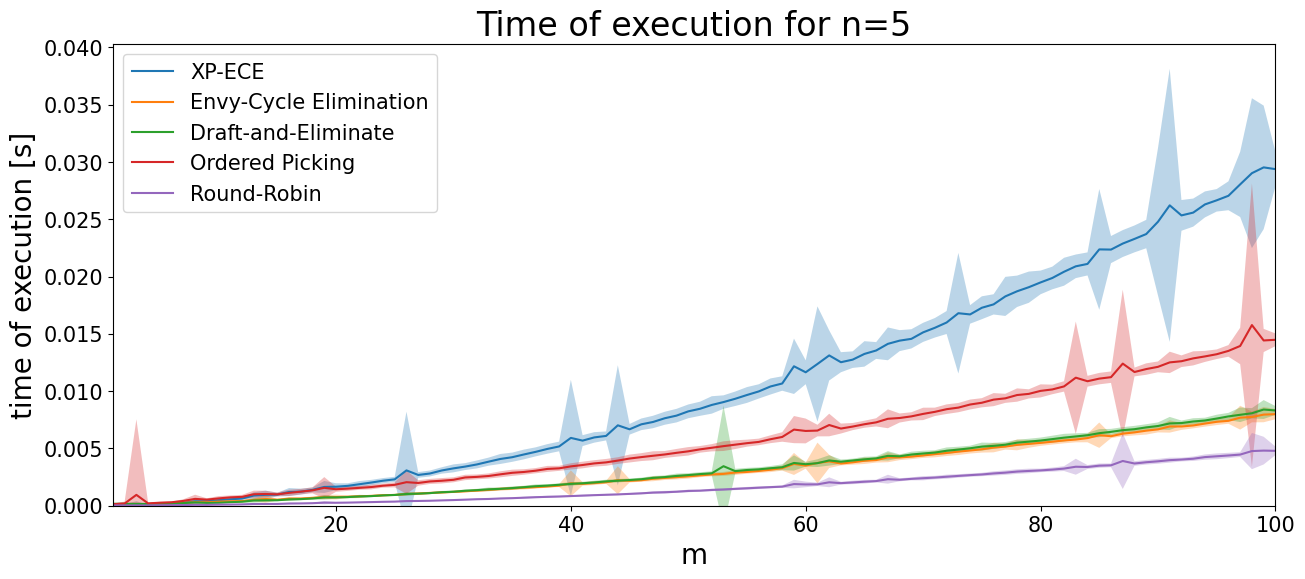

In [37]:
read_and_draw_statistics("data/comparison_execution_time_5.csv", "m", "time of execution [s]", "Time of execution for n=5")

### n = 10

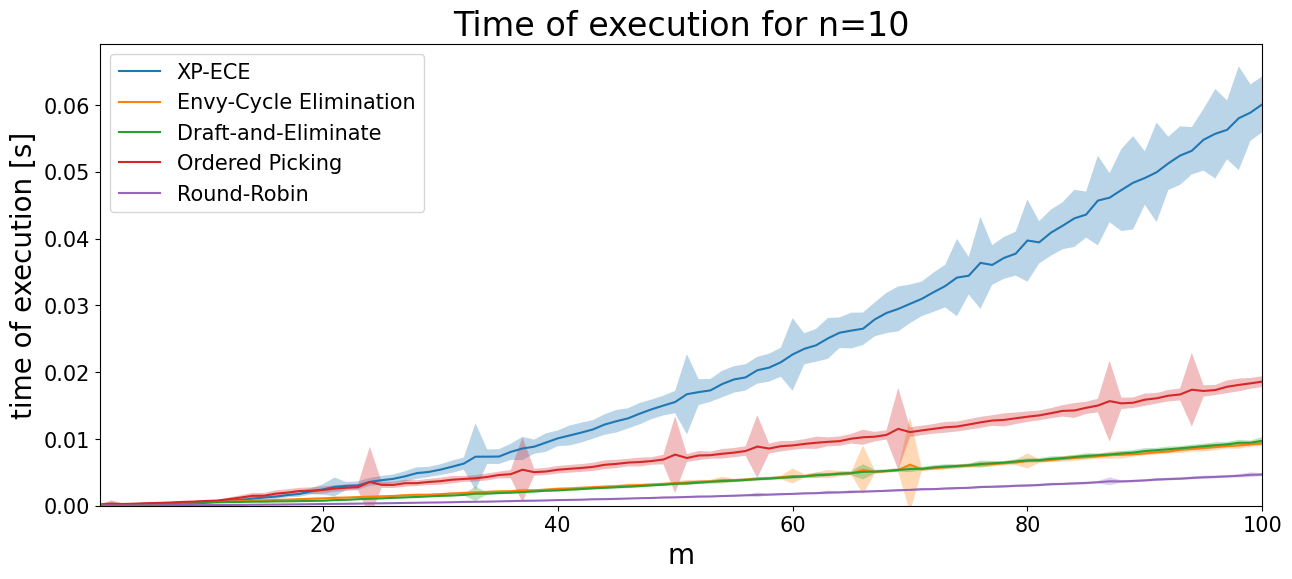

In [38]:
read_and_draw_statistics("data/comparison_execution_time_10.csv", "m", "time of execution [s]", "Time of execution for n=10")

### m = 4n

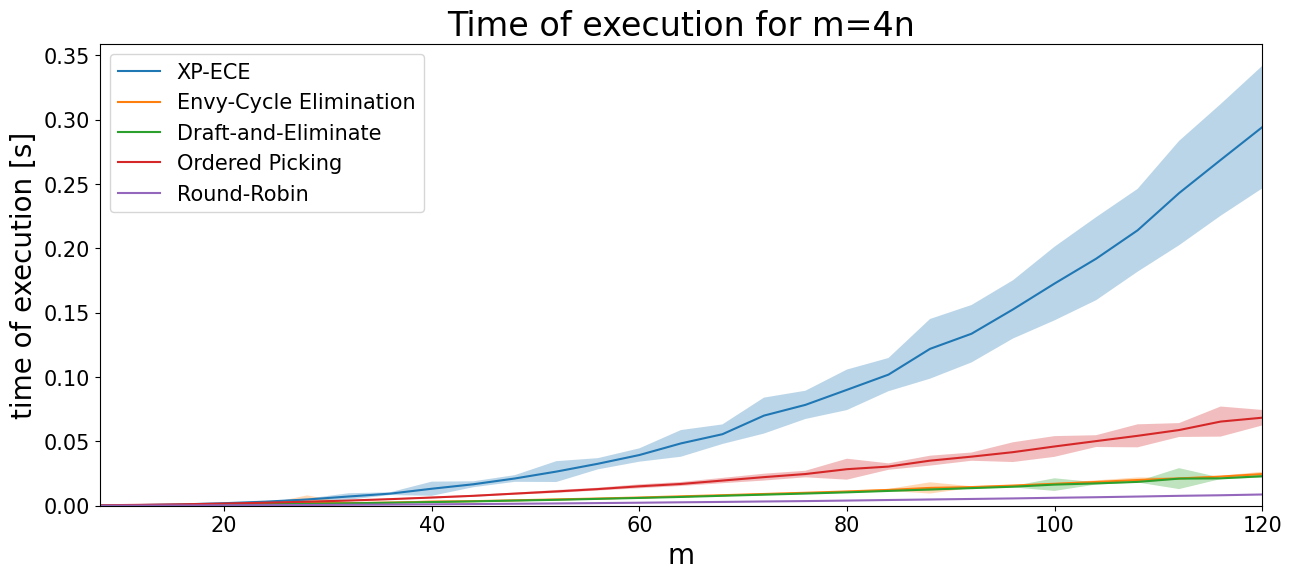

In [39]:
read_and_draw_statistics("data/comparison_execution_time_4n.csv", "m", "time of execution [s]", "Time of execution for m=4n")